In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

In [2]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            #Input = Nxchannels_imgx64x64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d*2, 4, 2, 1), #Nxfeatures_d*2x32x32
            self._block(features_d*2, features_d*4, 4, 2, 1), #Nxfeatures_d*4x16x16
            self._block(features_d*4, features_d*8, 4, 2, 1), #Nxfeatures_d*8x8x8
            self._block(features_d*8, features_d*16, 4, 2, 1), #Nxfeatures_d*16x4x4

            nn.Conv2d(features_d*16, 1, kernel_size=4, stride=2, padding=1), #Nx1x4x4
            ## Note: No sigmoid here
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #Input = N*z_dim*1*1
            self._block(z_dim, features_g*16, 4, 1, 0), #N*features_g*16*4*4
            self._block(features_g*16, features_g*8, 4, 2, 1), #N*features_g*8*8*8
            self._block(features_g*8, features_g*4, 4, 2, 1), #N*features_g*4*16*16
            self._block(features_g*4, features_g*2, 4, 2, 1), #N*features_g*2*32*32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), #N*channels_img*64*64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gen(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr = 5e-4 #vary 
z_dim = 100 #vary
img_dim = 64
channels_img = 1
batch_size = 64
num_epochs = 50
features_d = 64
features_g = 64

critic_iter = 5
weight_clip = 0.01

In [4]:
transformation = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

dataset = datasets.MNIST(root = "dataset", transform = transformation, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
critic = Critic(channels_img, features_d).to(device)
gen = Generator(z_dim, channels_img, features_g).to(device)

initialize_weights(critic)
initialize_weights(gen)

opt_critic = optim.RMSprop(critic.parameters(), lr = lr)
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)

In [6]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [7]:
def show(imgs): #Show function from pytorch.org
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Epoch [0/50] Batch 0/938 \Loss Critic: -0.4709, loss Generator: 0.2674
Epoch [1/50] Batch 0/938 \Loss Critic: -0.7449, loss Generator: 0.3705
Epoch [2/50] Batch 0/938 \Loss Critic: -0.4638, loss Generator: 0.3564
Epoch [3/50] Batch 0/938 \Loss Critic: -0.6916, loss Generator: 0.3544
Epoch [4/50] Batch 0/938 \Loss Critic: -0.3126, loss Generator: 0.0921
Epoch [5/50] Batch 0/938 \Loss Critic: -0.7141, loss Generator: 0.3600
Epoch [6/50] Batch 0/938 \Loss Critic: -0.6520, loss Generator: 0.3490
Epoch [7/50] Batch 0/938 \Loss Critic: -0.5973, loss Generator: 0.3323
Epoch [8/50] Batch 0/938 \Loss Critic: -0.3853, loss Generator: 0.3433
Epoch [9/50] Batch 0/938 \Loss Critic: -0.4425, loss Generator: 0.2971
Epoch [10/50] Batch 0/938 \Loss Critic: -0.5094, loss Generator: 0.3288
Epoch [11/50] Batch 0/938 \Loss Critic: -0.5582, loss Generator: 0.3443
Epoch [12/50] Batch 0/938 \Loss Critic: -0.5296, loss Generator: 0.3292
Epoch [13/50] Batch 0/938 \Loss Critic: -0.4176, loss Generator: 0.3506
Ep

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Epoch [21/50] Batch 0/938 \Loss Critic: -0.4160, loss Generator: 0.3405
Epoch [22/50] Batch 0/938 \Loss Critic: -0.3816, loss Generator: 0.3373
Epoch [23/50] Batch 0/938 \Loss Critic: -0.3608, loss Generator: 0.1623
Epoch [24/50] Batch 0/938 \Loss Critic: -0.3612, loss Generator: 0.1320
Epoch [25/50] Batch 0/938 \Loss Critic: -0.3276, loss Generator: 0.1198
Epoch [26/50] Batch 0/938 \Loss Critic: -0.3875, loss Generator: 0.3159
Epoch [27/50] Batch 0/938 \Loss Critic: -0.3614, loss Generator: 0.1205
Epoch [28/50] Batch 0/938 \Loss Critic: -0.4710, loss Generator: 0.2465
Epoch [29/50] Batch 0/938 \Loss Critic: -0.4486, loss Generator: 0.1613
Epoch [30/50] Batch 0/938 \Loss Critic: -0.4646, loss Generator: 0.2537
Epoch [31/50] Batch 0/938 \Loss Critic: -0.4925, loss Generator: 0.3315
Epoch [32/50] Batch 0/938 \Loss Critic: -0.2489, loss Generator: 0.3209
Epoch [33/50] Batch 0/938 \Loss Critic: -0.3500, loss Generator: 0.3272
Epoch [34/50] Batch 0/938 \Loss Critic: -0.4438, loss Generator:

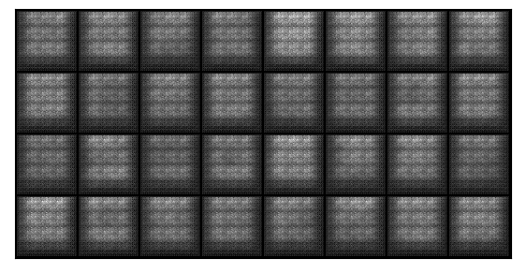

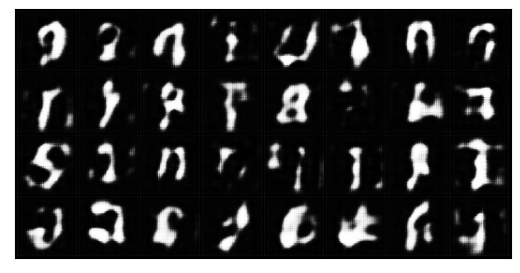

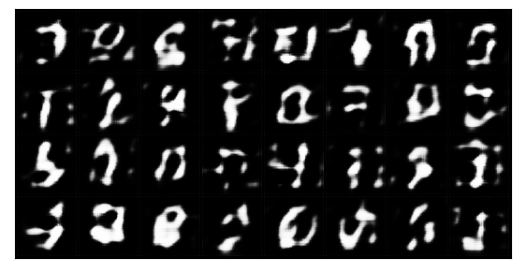

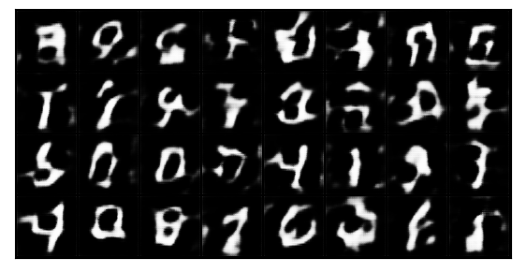

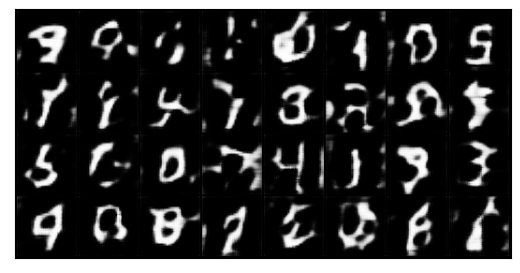

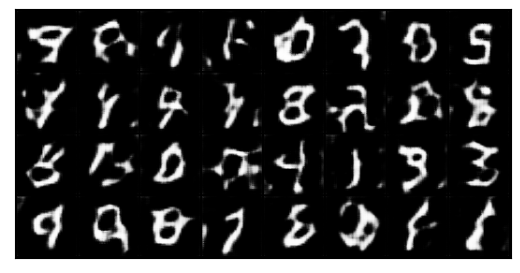

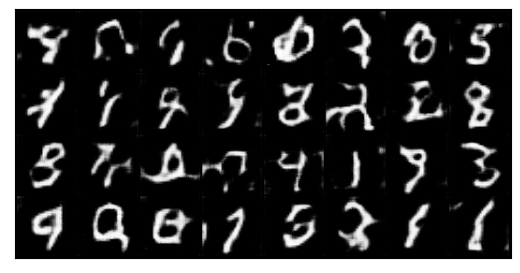

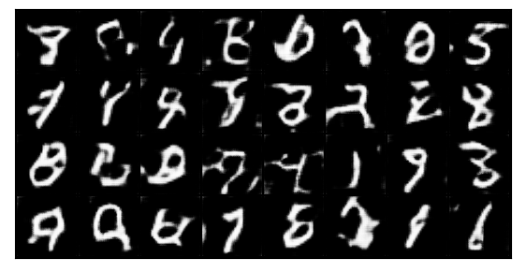

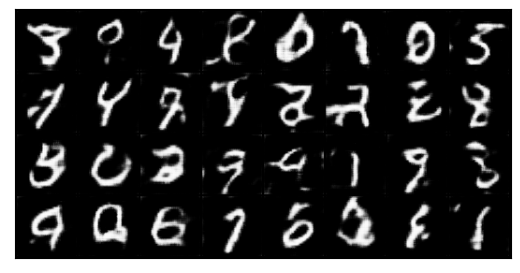

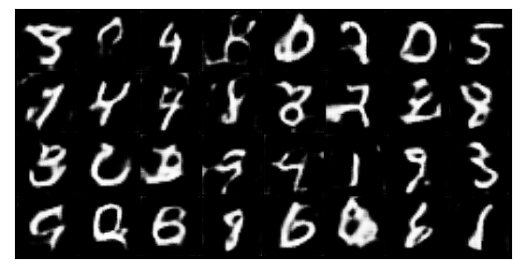

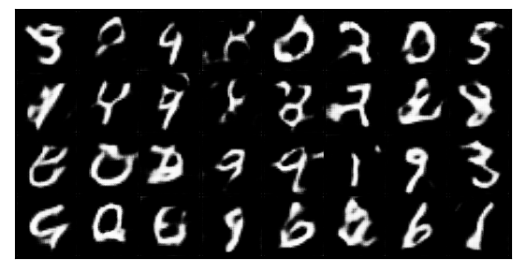

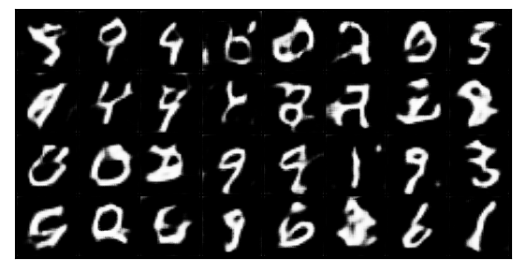

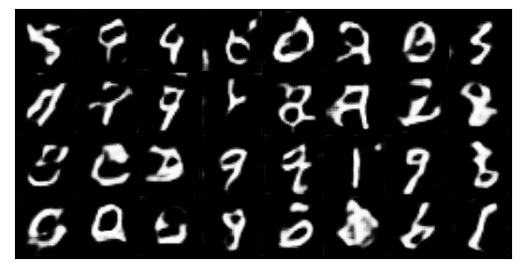

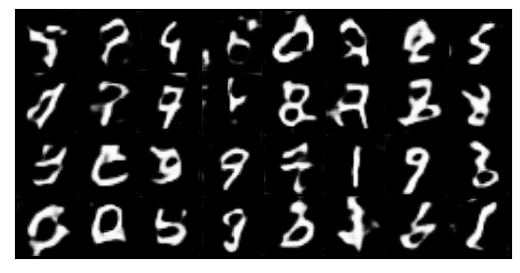

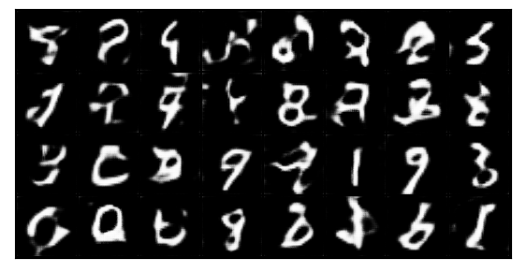

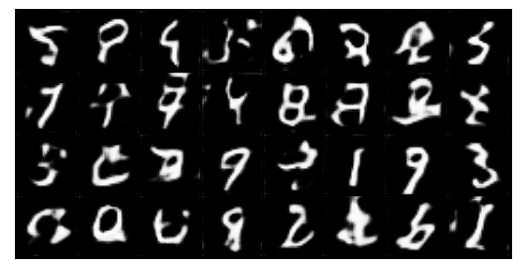

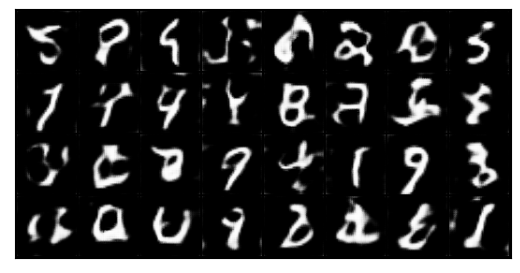

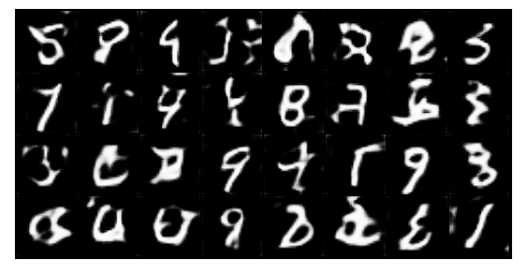

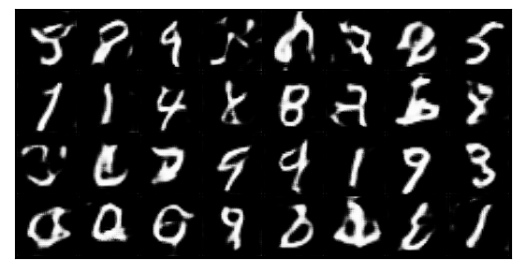

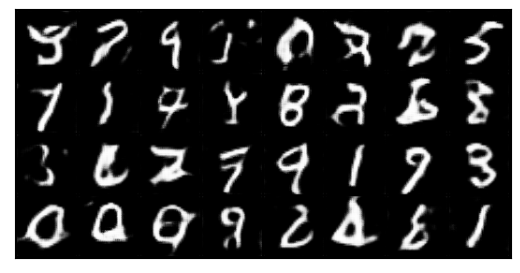

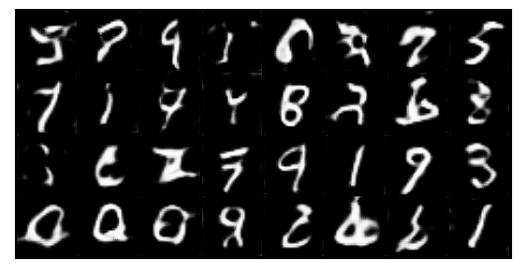

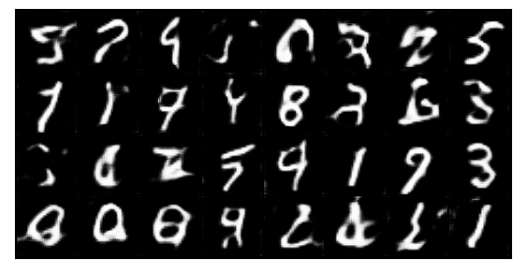

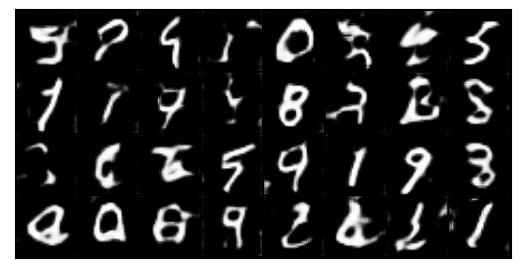

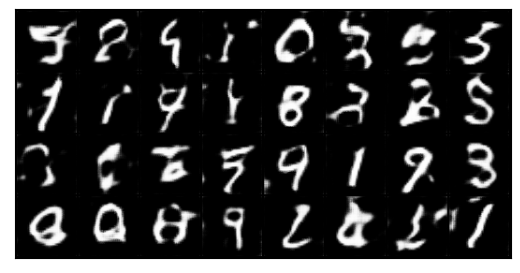

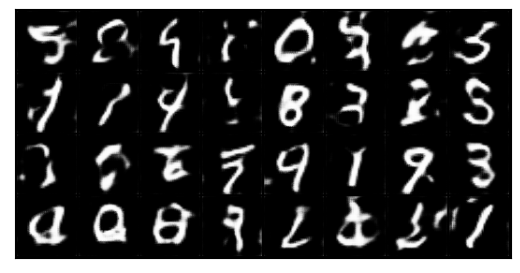

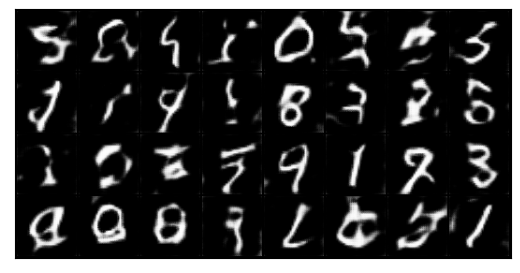

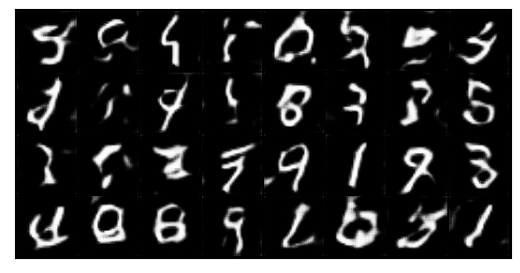

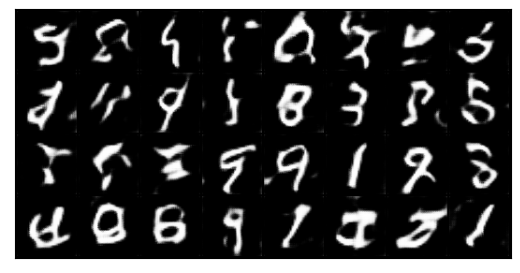

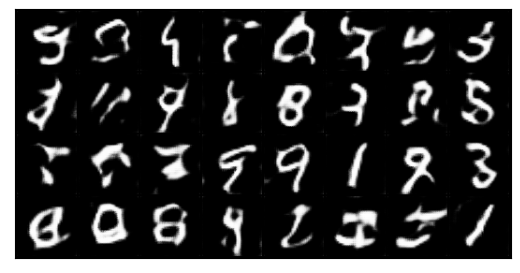

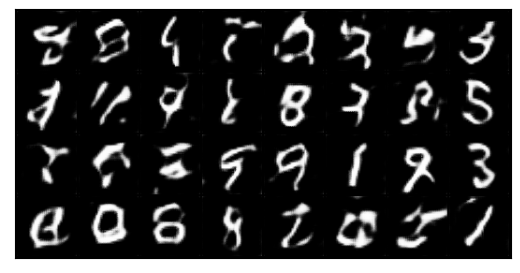

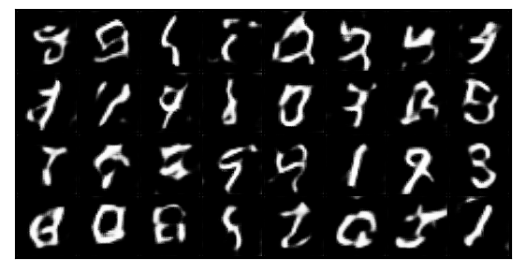

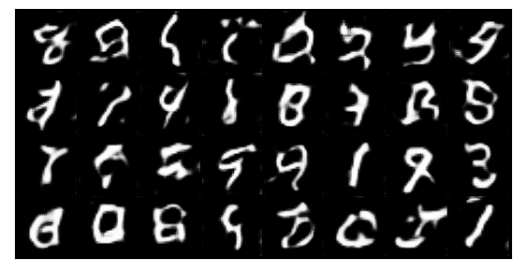

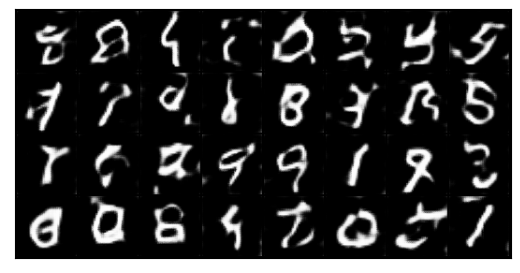

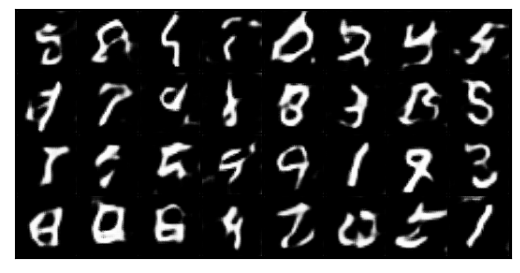

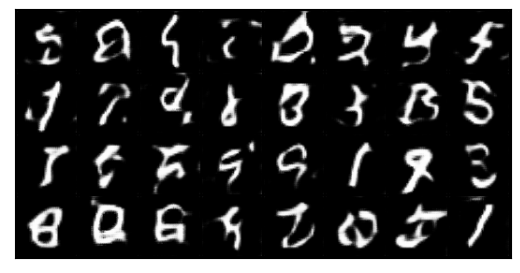

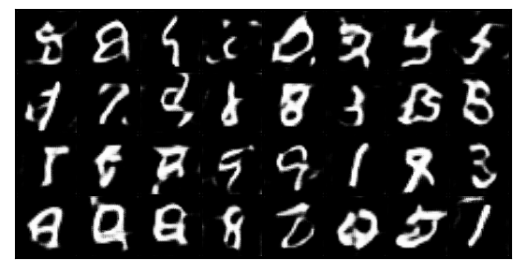

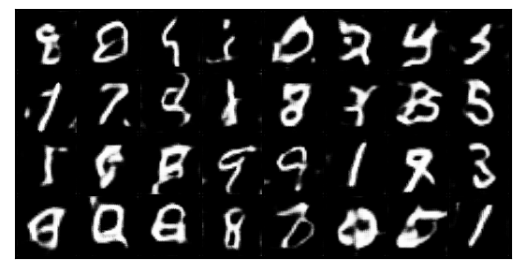

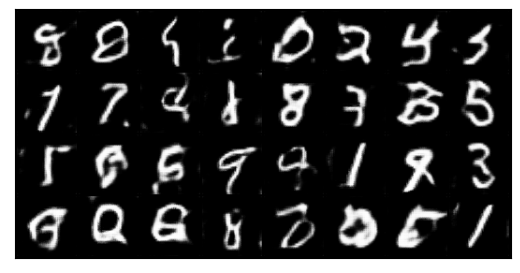

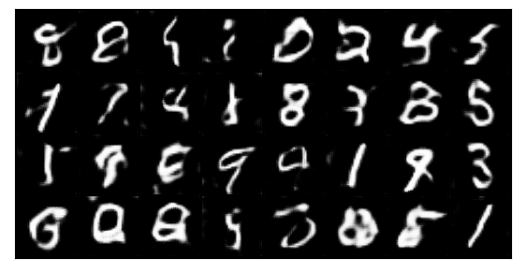

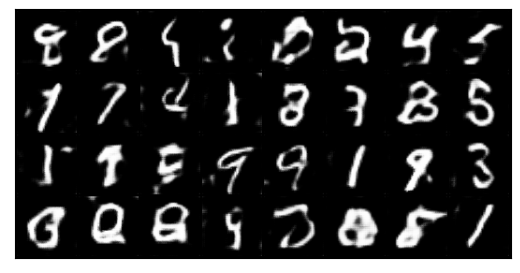

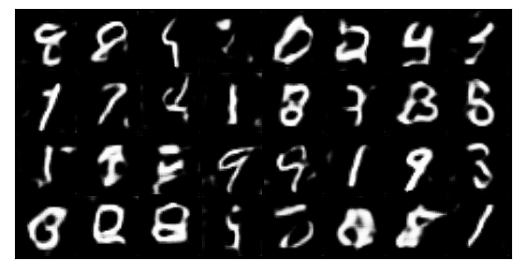

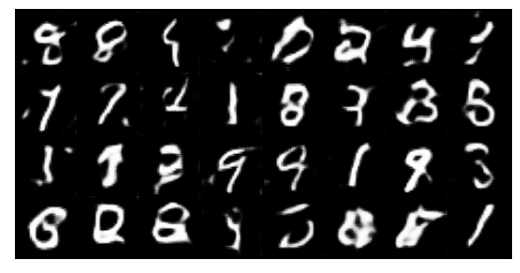

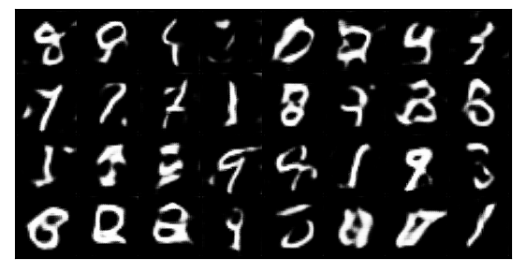

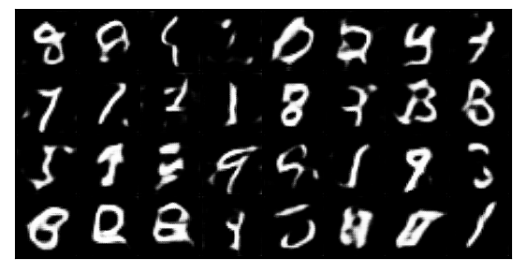

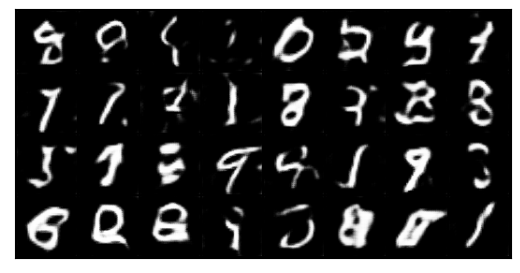

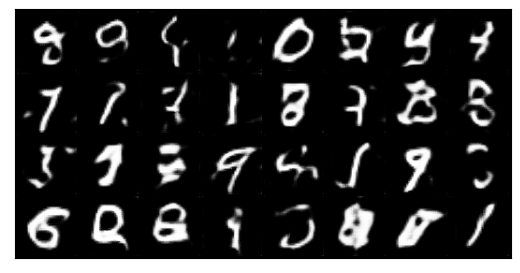

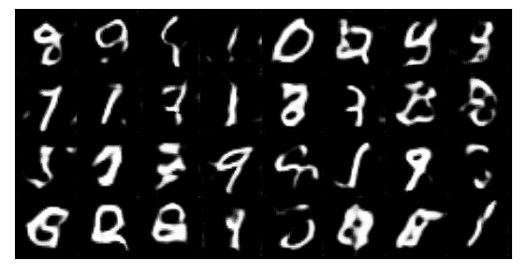

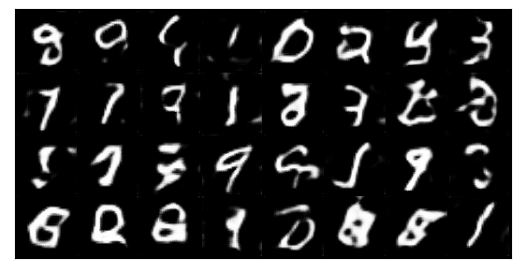

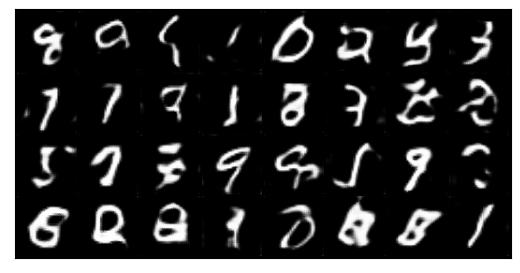

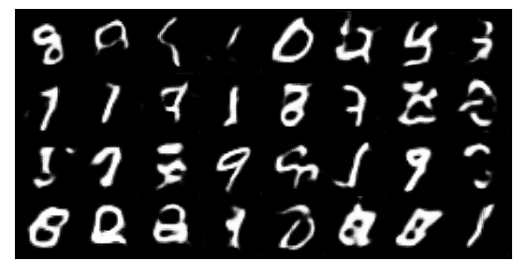

In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]
        
        # Train Critic Max E[critic(real)] - E[critic(fake)]
        for _ in range(critic_iter):
            noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
            fake = gen(noise)

            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            critic.zero_grad()
            loss_critic.backward(retain_graph = True)# a
            opt_critic.step()

            for para in critic.parameters():
                para.data.clamp_(-weight_clip, weight_clip)

        # Train Gen Min -E[critic(fake)]

        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)

        gen.zero_grad()
        loss_gen.backward(retain_graph = True)# a
        opt_gen.step()


###################################################
        if (batch_idx == 0):
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \Loss Critic: {loss_critic:.4f}, loss Generator: {loss_gen:.4f}")

            if (batch_idx == 0):
                with torch.no_grad():
                    fake = gen(fixed_noise).reshape(-1, channels_img, img_dim, img_dim)
                    img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                    show(img_grid_fake)
####################################################